In [1]:
# Data and Stats packages
import numpy as np
import pandas as pd
import re
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

# Other
import itertools

# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 500)
sns.set_style('whitegrid')
sns.set_context('talk')

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import data
df_07to11 = pd.read_csv('./data/LoanStats3a.csv',header=1)
df_2016Q1 = pd.read_csv('./data/LoanStats_2016Q1.csv',header=1)
df_2016Q2 = pd.read_csv('./data/LoanStats_2016Q2.csv',header=1)
df_2016Q3 = pd.read_csv('./data/LoanStats_2016Q3.csv',header=1)
df_2016Q4 = pd.read_csv('./data/LoanStats_2016Q4.csv',header=1)

In [3]:
#concat quarterly dfs for 2016
df_16 = pd.concat([df_2016Q1,df_2016Q2,df_2016Q3,df_2016Q4])

In [4]:
#figure out index when 2007 data begins
not07 = True
i = 0
while(not07):
    val = df_07to11['issue_d'].values[i][-2:]  
    if val == '07':
        print(i)
        not07 = False
    i+=1

39533


In [5]:
df_16.shape

(434415, 145)

In [6]:
#drop all data points before this (2008-2011 data)
df_07 = df_07to11.drop(np.arange(39533))

In [7]:
#function to clean datasets
def clean(df):
    preds = ['loan_status'
         ,'loan_amnt'
         ,'funded_amnt'
         ,'term'
         ,'int_rate'
         ,'installment'
         ,'emp_length'
         ,'home_ownership'
         ,'annual_inc'
         ,'issue_d'
         ,'zip_code'
         ,'addr_state'
         ,'dti'
         ,'delinq_2yrs'
         ,'earliest_cr_line'
         ,'inq_last_6mths'
         ,'mths_since_last_delinq'
         ,'open_acc'
         ,'pub_rec'
         ,'revol_bal'
         ,'revol_util'
         ,'total_acc'
        ]

    states = df['addr_state'].unique().tolist()
    
    df = df[preds]

    df['term'] = df['term'].str.rstrip(' months').astype('float')
    df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float') / 100.0
    df['emp_length'] = df['emp_length'].str.strip('< + years').astype('float')
    df['issue_d'] = pd.to_datetime(df['issue_d'])
    df['zip_code'] = df['zip_code'].str.replace('xx','00').astype('float')
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
    
    df['length_credit_history'] = (df['issue_d']-df['earliest_cr_line']).astype('timedelta64[D]')/30.44
    df['mths_since_last_delinq'] = np.where(df['mths_since_last_delinq'].isna() , df['length_credit_history'], df['mths_since_last_delinq'])
    df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float') / 100.0
    df = pd.get_dummies(df, columns = ['home_ownership'] )
    df = pd.get_dummies(df, columns = ['addr_state'] )

    df['loan_status'] = np.where(df['loan_status'] == 'Fully Paid' , 'paid', df['loan_status'])
    df['loan_status'] = np.where(df['loan_status'] == 'Charged Off' , 'default', df['loan_status'])
    df['loan_status'] = np.where(df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'paid', df['loan_status'])
    df['loan_status'] = np.where(df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'default', df['loan_status'])
    
    preds.append('length_credit_history')

    df = df.dropna()
    return df

In [8]:
#clean the dfs
df_07 = clean(df_07)
df_16 = clean(df_16)

In [9]:
df_16.shape

(405945, 75)

In [15]:
paid07 = df_07[df_07['loan_status'] == 'paid']

In [18]:
default07 = df_07[df_07['loan_status'] == 'default']

In [22]:
paid16 = df_16[df_16['loan_status'] == 'paid']
default16 = df_16[df_16['loan_status'] == 'default']

In [21]:
print('paid ' + str(paid07.shape[0]))
print('default ' + str(default07.shape[0]))
print('total = ' + str(paid07.shape[0] + default07.shape[0]))

paid 2142
default 786
total = 2928


In [23]:
print('paid ' + str(paid16.shape[0]))
print('default ' + str(default16.shape[0]))
print('total = ' + str(paid16.shape[0] + default16.shape[0]))

paid 167651
default 55760
total = 223411


In [24]:
df2016 = pd.concat([paid16, default16])
df2007 = pd.concat([paid07, default07])

In [33]:
df2007['loan_status'] = np.where(df2007['loan_status'] == 'paid' , 1, 0)

In [35]:
df2016['loan_status'] = np.where(df2016['loan_status'] == 'paid' , 1, 0)

In [39]:
df_07 = pd.DataFrame(df2007)
df_16 = pd.DataFrame(df2016)

In [40]:
#Remove datetime columns and interest rates
# Maybe we should remove other columns as well
cols_to_remove = ['int_rate', 'issue_d', 'earliest_cr_line']
df_07 = df_07.drop(cols_to_remove, axis = 1)
df_16 = df_16.drop(cols_to_remove, axis = 1)

In [53]:
# Normalize Data
to_norm = ['loan_amnt', 'term', 'funded_amnt', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
          'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
          'total_acc','length_credit_history']

In [54]:
from scipy.stats import zscore
def norm(df, cols):
    for e in cols:
        df[e] = zscore(df[e])
    return df

In [55]:
df_07 = norm(df_07, to_norm)
df_16 = norm(df_16, to_norm)

In [56]:
df_07.head()

,loan_status,loan_amnt,funded_amnt,term,installment,emp_length,annual_inc,zip_code,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,length_credit_history,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
39533,1,1.733543,1.810206,-0.339122,1.748339,1.687766,-0.486201,87100.0,0.020189,-0.323344,-0.294364,-0.871860,-0.361456,-0.29228,-0.082471,0.062502,-0.600404,-0.969111,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39534,1,1.733543,1.810206,-0.339122,1.895037,-0.684241,-0.428638,90200.0,0.245137,-0.323344,-1.264972,-0.335137,-0.898867,-0.29228,-0.297722,1.538819,-0.021716,-0.237640,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39535,1,-0.260427,-0.232299,-0.339122,-0.244175,-0.980741,-0.465491,3100.0,-0.242703,2.381657,-0.294364,-0.634704,-0.182319,-0.29228,-0.318792,-0.731105,-0.817412,-0.121703,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39538,1,-1.010160,-1.000280,-0.339122,-1.002427,-0.980741,-0.620185,34900.0,-1.345764,-0.323344,-0.941436,-0.871860,-0.361456,-0.29228,-0.423476,-1.625213,-0.528068,-0.156027,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39539,1,-0.180668,-0.150598,-0.339122,-0.211060,-0.387740,-0.260793,60600.0,-0.467652,-0.323344,-0.941436,-0.871860,1.788190,-0.29228,-0.453700,-1.798489,1.425005,-0.341755,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
#Split data into train and test
df_07_train, df_07_test = train_test_split(df_07, test_size=0.2, random_state=90)
df_16_train, df_16_test = train_test_split(df_16, test_size=0.2, random_state=90)

#Split to x and y
df_07_X_train = df_07_train.drop(labels = 'loan_status', axis = 1)
df_07_y_train = df_07_train.loan_status
df_07_X_test = df_07_test.drop(labels = 'loan_status', axis = 1)
df_07_y_test = df_07_test.loan_status

df_16_X_train = df_16_train.drop(labels = 'loan_status', axis = 1)
df_16_y_train = df_16_train.loan_status
df_16_X_test = df_16_test.drop(labels = 'loan_status', axis = 1)
df_16_y_test = df_16_test.loan_status

In [58]:
#Trivial Model in which all loans are accepted
triv_mod_07_train = np.sum(df_07_y_train)/len(df_07_y_train)
triv_mod_07_test = np.sum(df_07_y_test)/len(df_07_y_test)
print('2007 Data\nTrain score: '+str(triv_mod_07_train))
print('Test score: '+str(triv_mod_07_test))
triv_mod_16_train = np.sum(df_16_y_train)/len(df_16_y_train)
triv_mod_16_test = np.sum(df_16_y_test)/len(df_16_y_test)
print('2016 Data\nTrain score: '+str(triv_mod_16_train))
print('Test score: '+str(triv_mod_16_test))

2007 Data
Train score: 0.7297181895815542
Test score: 0.7389078498293515
2016 Data
Train score: 0.7504867731972606
Test score: 0.750128684287089


In [59]:
#Logistiv regression on 2007 data
log_mod07 = LogisticRegressionCV().fit(df_07_X_train, df_07_y_train.values)

log_mod07_train_score = log_mod07.score(df_07_X_train,df_07_y_train.values)
log_mod07_test_score =log_mod07.score(df_07_X_test,df_07_y_test.values)
print("The accuracy of Logistic Regression Model on Training Set is ", log_mod07_train_score)
print("The accuracy of Logistic Regression Model on Testing Set is ", log_mod07_test_score)

The accuracy of Logistic Regression Model on Training Set is  0.7297181895815542
The accuracy of Logistic Regression Model on Testing Set is  0.7389078498293515


In [60]:
#Logistic regression on 2016 data
log_mod16 = LogisticRegressionCV().fit(df_16_X_train, df_16_y_train.values)

log_mod16_train_score = log_mod16.score(df_16_X_train, df_16_y_train.values)
log_mod16_test_score = log_mod16.score(df_16_X_test, df_16_y_test.values)
print("The accuracy of Logistic Regression Model on Training Set is ", log_mod16_train_score)
print("The accuracy of Logistic Regression Model on Testing Set is ", log_mod16_test_score)

The accuracy of Logistic Regression Model on Training Set is  0.7504867731972606
The accuracy of Logistic Regression Model on Testing Set is  0.750128684287089


In [61]:
# kNN model for 2007 data
knn07 = KNeighborsClassifier(n_neighbors=20).fit(df_07_X_train, df_07_y_train.values)

knn07_train_score = knn07.score(df_07_X_train, df_07_y_train.values)
knn07_test_score = knn07.score(df_07_X_test, df_07_y_test.values)

print("The accuracy of K-NN Model on Training Set is ", knn07_train_score)
print("The accuracy of K-NN Model on Testing Set is ", knn07_test_score)

The accuracy of K-NN Model on Training Set is  0.7305721605465414
The accuracy of K-NN Model on Testing Set is  0.7286689419795221


In [62]:
# kNN model for 2016 data
knn16 = KNeighborsClassifier(n_neighbors=20).fit(df_16_X_train, df_16_y_train.values)

knn16_train_score = knn16.score(df_16_X_train, df_16_y_train.values)
knn16_test_score = knn16.score(df_16_X_test, df_16_y_test.values)

print("The accuracy of K-NN Model on Training Set is ", knn16_train_score)
print("The accuracy of K-NN Model on Testing Set is ", knn16_test_score)

The accuracy of K-NN Model on Training Set is  0.7586276352893783
The accuracy of K-NN Model on Testing Set is  0.7454960499518832


In [63]:
# tree model for 2007 data
tree07 = DecisionTreeClassifier(max_depth = 4).fit(df_07_X_train, df_07_y_train.values)

tree07_train_score = tree07.score(df_07_X_train, df_07_y_train.values)
tree07_test_score = tree07.score(df_07_X_test, df_07_y_test.values)

print("The accuracy of Tree Model on Training Set is ", tree07_train_score)
print("The accuracy of Tree Model on Testing Set is ", tree07_test_score)

The accuracy of Tree Model on Training Set is  0.7433817250213492
The accuracy of Tree Model on Testing Set is  0.7320819112627986


In [64]:
# tree model for 2016 data
tree16 = DecisionTreeClassifier(max_depth = 4).fit(df_16_X_train, df_16_y_train.values)

tree16_train_score = tree16.score(df_16_X_train, df_16_y_train.values)
tree16_test_score = tree16.score(df_16_X_test, df_16_y_test.values)

print("The accuracy of Tree Model on Training Set is ", tree16_train_score)
print("The accuracy of Tree Model on Testing Set is ", tree16_test_score)

The accuracy of Tree Model on Training Set is  0.7521764916521194
The accuracy of Tree Model on Testing Set is  0.7530380681691023


In [65]:
# Get train score, cross val score means and stds
train_scores = []
cvmeans = []
cvstds = []
depths = list(range(1, 15))
#for all specified maximum tree depths --> fit model and add scores to list
for i in depths:
    #create/fit model
    tree = DecisionTreeClassifier(max_depth = i).fit(df_07_X_train, df_07_y_train.values) 
    train_scores.append(tree.score(df_07_X_train, df_07_y_train.values))
    score = cross_val_score(estimator=tree, X=df_07_X_train, y=df_07_y_train.values, cv=5)
    cvmeans.append(score.mean())
    cvstds.append(score.std())
    
cvstds = np.array(cvstds)
cvmeans = np.array(cvmeans)

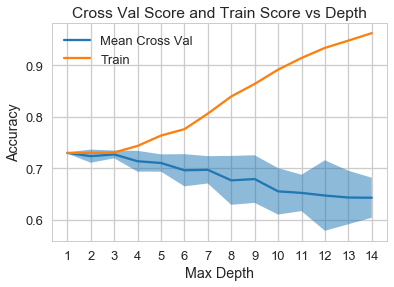

In [66]:
#create plot
plt.plot(depths, cvmeans, label="Mean Cross Val")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.5)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths)
plt.title("Cross Val Score and Train Score vs Depth");

In [67]:
randy07 = RandomForestClassifier(n_estimators = 45, max_depth = 6).fit(df_07_X_train, df_07_y_train.values)
randy07_train_score = randy07.score(df_07_X_train, df_07_y_train.values)
randy07_test_score = randy07.score(df_07_X_test, df_07_y_test.values)
print("The accuracy of Randy Model on Training Set is ", randy07_train_score)
print("The accuracy of Randy Model on Testing Set is ", randy07_test_score)

The accuracy of Randy Model on Training Set is  0.7361229718189581
The accuracy of Randy Model on Testing Set is  0.7389078498293515


In [68]:
randy16 = RandomForestClassifier(n_estimators = 45, max_depth = 6).fit(df_16_X_train, df_16_y_train.values)
randy16_train_score = randy16.score(df_16_X_train, df_16_y_train.values)
randy16_test_score = randy16.score(df_16_X_test, df_16_y_test.values)
print("The accuracy of Randy Model on Training Set is ", randy16_train_score)
print("The accuracy of Randy Model on Testing Set is ", randy16_test_score)

The accuracy of Randy Model on Training Set is  0.7504867731972606
The accuracy of Randy Model on Testing Set is  0.750128684287089


In [69]:
ada07 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6), n_estimators=800, learning_rate=0.05).fit(df_07_X_train, df_07_y_train.values)
ada07_train_score = ada07.score(df_07_X_train, df_07_y_train.values)
ada07_test_score = ada07.score(df_07_X_test, df_07_y_test.values)
print("The accuracy of Randy Model on Training Set is ", ada07_train_score)
print("The accuracy of Randy Model on Testing Set is ", ada07_test_score)

The accuracy of Randy Model on Training Set is  1.0
The accuracy of Randy Model on Testing Set is  0.735494880546075


In [77]:
# Takes a while to run
#ada16 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6), n_estimators=800, learning_rate=0.05).fit(df_16_X_train, df_16_y_train.values)
#ada16_train_score = ada16.score(df_16_X_train, df_16_y_train.values)
#ada16_test_score = ada16.score(df_16_X_test, df_16_y_test.values)
#print("The accuracy of Randy Model on Training Set is ", ada16_train_score)
#print("The accuracy of Randy Model on Testing Set is ", ada16_test_score)

In [71]:
#Build an LDA Model and report train and test accuracy
lda07 = LinearDiscriminantAnalysis().fit(df_07_X_train, df_07_y_train.values)
lda07_train_score = lda07.score(df_07_X_train, df_07_y_train.values)
lda07_test_score = lda07.score(df_07_X_test, df_07_y_test.values)
print("The accuracy of LDA Model on Training Set is ", lda07_train_score)
print("The accuracy of LDA Model on Testing Set is ", lda07_test_score)

The accuracy of LDA Model on Training Set is  0.7318531169940222
The accuracy of LDA Model on Testing Set is  0.7167235494880546


In [72]:
#Build an LDA Model and report train and test accuracy
lda16 = LinearDiscriminantAnalysis().fit(df_16_X_train, df_16_y_train.values)
lda16_train_score = lda16.score(df_16_X_train, df_16_y_train.values)
lda16_test_score = lda16.score(df_16_X_test, df_16_y_test.values)
print("The accuracy of LDA Model on Training Set is ", lda16_train_score)
print("The accuracy of LDA Model on Testing Set is ", lda16_test_score)

The accuracy of LDA Model on Training Set is  0.7556230696924936
The accuracy of LDA Model on Testing Set is  0.7550970167625272


In [73]:
qda07 = QuadraticDiscriminantAnalysis().fit(df_07_X_train, df_07_y_train.values)

qda07_train_score = qda07.score(df_07_X_train, df_07_y_train.values)
qda07_test_score = qda07.score(df_07_X_test, df_07_y_test.values)

print("The accuracy of QDA Model on Training Set is ", qda07_train_score)
print("The accuracy of QDA Model on Testing Set is ", qda07_test_score)

The accuracy of QDA Model on Training Set is  0.2941929974380871
The accuracy of QDA Model on Testing Set is  0.2696245733788396


In [74]:
qda16 = QuadraticDiscriminantAnalysis().fit(df_16_X_train, df_16_y_train.values)

qda16_train_score = qda16.score(df_16_X_train, df_16_y_train.values)
qda16_test_score = qda16.score(df_16_X_test, df_16_y_test.values)

print("The accuracy of QDA Model on Training Set is ", qda16_train_score)
print("The accuracy of QDA Model on Testing Set is ", qda16_test_score)

The accuracy of QDA Model on Training Set is  0.3825086164451009
The accuracy of QDA Model on Testing Set is  0.3788465411901618


In [75]:
svm07 = SVC().fit(df_07_X_train, df_07_y_train.values)

svm07_train_score = svm07.score(df_07_X_train, df_07_y_train.values)
svm07_test_score = svm07.score(df_07_X_test, df_07_y_test.values)

print("The accuracy of SVC Model on Training Set is ", svm07_train_score)
print("The accuracy of SVC Model on Testing Set is ", svm07_test_score)

The accuracy of SVC Model on Training Set is  0.7937660119555935
The accuracy of SVC Model on Testing Set is  0.7252559726962458


In [78]:
# Talk about each model
# Talk about optimzing random forest
# Talk about coefficients of Logistic Regression